# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
import xgboost as xgb

Anomaly Detection Evaluation:
Isolation Forest Anomaly Detection Accuracy: 0.42
One-Class SVM Anomaly Detection Accuracy: 0.40
LOF Anomaly Detection Accuracy: 0.39

Regression Evaluation:
Evaluating Ridge...
Ridge MSE: 10007.11
Ridge R^2: 0.68
Ridge Best Params: {'model__alpha': 1.0}


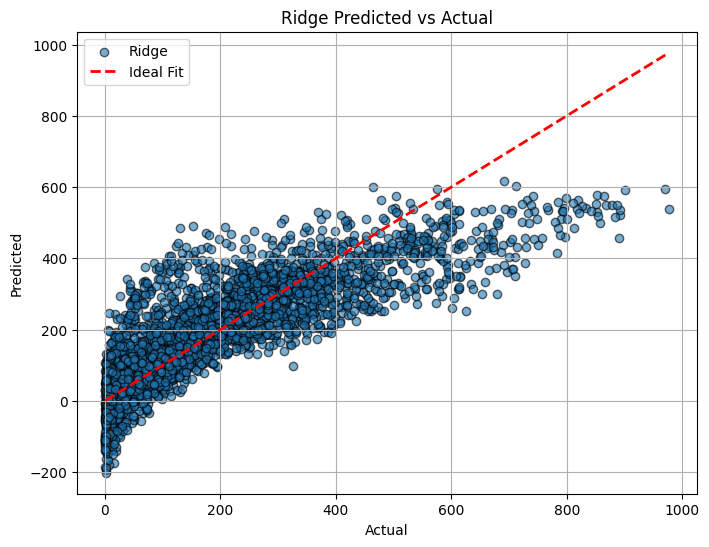

Evaluating Lasso...
Lasso MSE: 10004.78
Lasso R^2: 0.68
Lasso Best Params: {'model__alpha': 0.01}


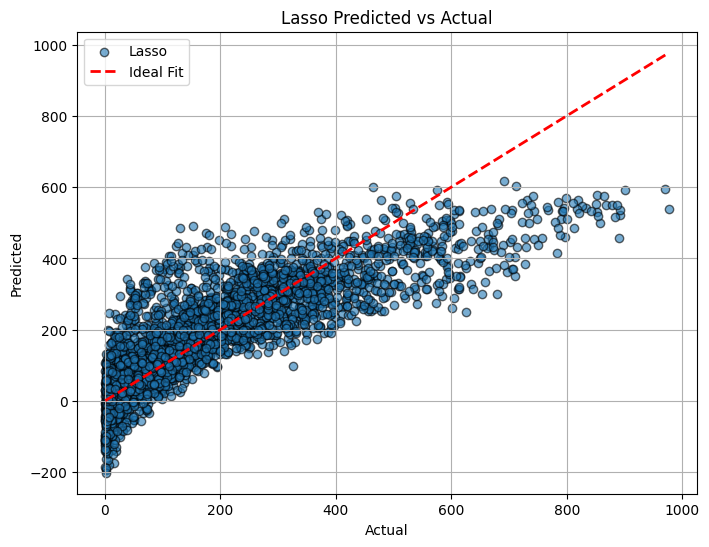

Evaluating Random Forest...
Random Forest MSE: 290.07
Random Forest R^2: 0.99
Random Forest Best Params: {'model__max_depth': None, 'model__n_estimators': 200}


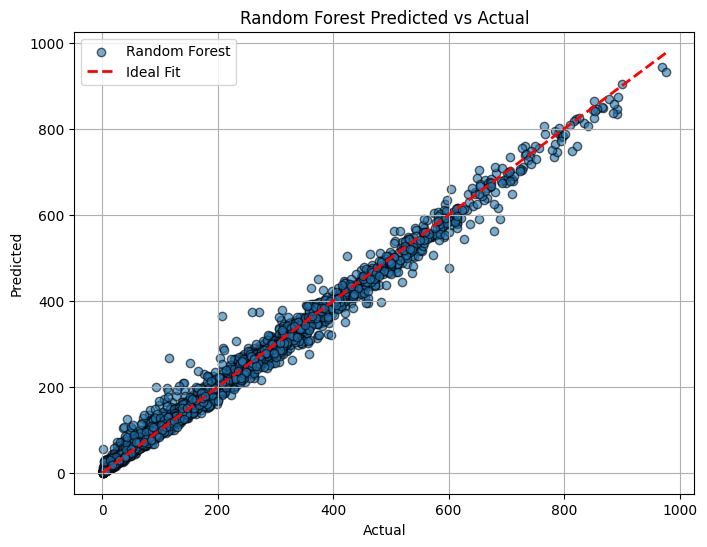

Evaluating Gradient Boosting...
Gradient Boosting MSE: 2864.68
Gradient Boosting R^2: 0.91
Gradient Boosting Best Params: {'model__learning_rate': 0.2, 'model__n_estimators': 200}


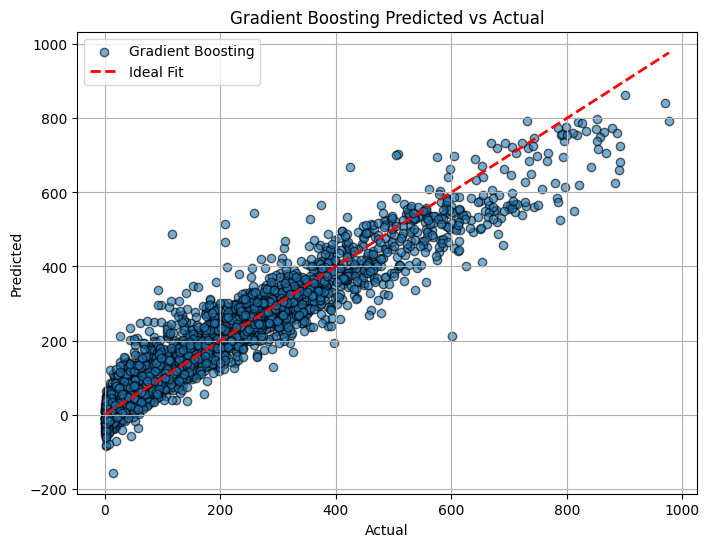

Evaluating XGBoost...
XGBoost MSE: 758.49
XGBoost R^2: 0.98
XGBoost Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 6, 'model__n_estimators': 200}


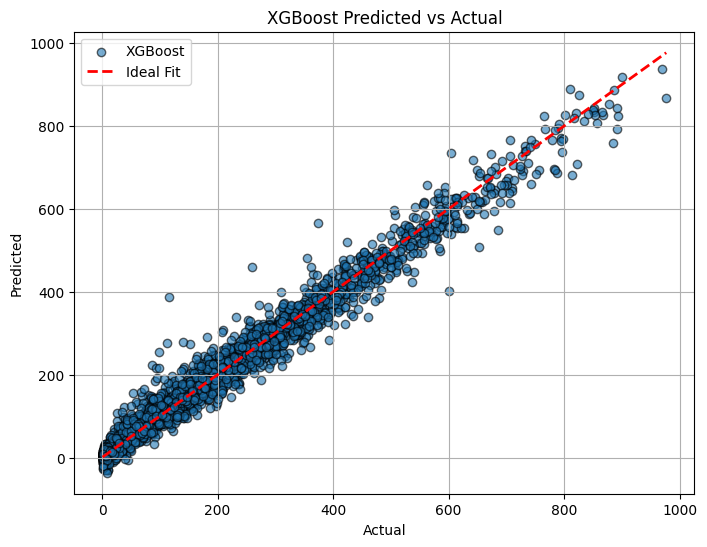

In [ ]:

df = pd.read_csv('motorbike_ambulance_calls.csv')
categorical_columns = ['season', 'holiday', 'weekday', 'workingday', 'weathersit', 'mnth', 'hr', 'yr']
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed']

df[categorical_columns] = df[categorical_columns].astype('category')
df['cnt'] = df['cnt'].astype(int)

def impute_missing_values(data, numerical_cols, categorical_cols):
    knn_imputer = KNNImputer(n_neighbors=5)
    data[numerical_cols] = knn_imputer.fit_transform(data[numerical_cols])
    data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])
    return data

df = impute_missing_values(df, numerical_columns, categorical_columns)

X = df.drop(columns=['cnt', 'index', 'date'], errors='ignore')
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

anomaly_models = [
    ('Isolation Forest', IsolationForest(n_estimators=100, contamination=0.1, random_state=42)),
    ('One-Class SVM', OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)),
    ('LOF', LocalOutlierFactor(n_neighbors=20, novelty=True))
]

print("Anomaly Detection Evaluation:")
for model_name, model in anomaly_models:
    model.fit(X_train_preprocessed)
    if hasattr(model, 'novelty'):
        pred = model.predict(X_test_preprocessed)
    else:
        pred = model.predict(X_test_preprocessed)
    pred = (pred == -1).astype(int)  
    baseline_anomaly = (y_test < y_test.mean()).astype(int)
    accuracy = accuracy_score(baseline_anomaly, pred)
    print(f"{model_name} Anomaly Detection Accuracy: {accuracy:.2f}")

regression_models = [
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', xgb.XGBRegressor(random_state=42))
]

param_grids = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'alpha': [0.01, 0.1, 1.0]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 9]}
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nRegression Evaluation:")
for model_name, model in regression_models:
    print(f"Evaluating {model_name}...")
    
    if model_name in param_grids:
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(
            Pipeline([('preprocessor', preprocessor), ('model', model)]),
            param_grid={'model__' + k: v for k, v in param_grid.items()},
            cv=kf,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X, y)
        best_estimator = grid_search.best_estimator_
        y_pred = best_estimator.predict(X_test)
        best_params = grid_search.best_params_
    else:
        pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        best_params = None

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} MSE: {mse:.2f}")
    print(f"{model_name} R^2: {r2:.2f}")
    if best_params:
        print(f"{model_name} Best Params: {best_params}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k', label=f'{model_name}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
    plt.title(f"{model_name} Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()
    plt.grid()
    plt.show()


### Data Overview and Preprocessing  

The motorbike ambulance dataset consisted of both numerical and categorical features, describing factors like temperature, humidity, weather conditions, and time-related aspects such as the hour of the day and the season. Below is a summary of the dataset after preprocessing:

| **Feature**         | **Type**       | **Description**                                             |
|----------------------|----------------|-------------------------------------------------------------|
| `temp`              | Numerical      | Normalized temperature in Celsius                           |
| `atemp`             | Numerical      | "Feels-like" temperature                                    |
| `hum`               | Numerical      | Humidity level                                              |
| `windspeed`         | Numerical      | Wind speed                                                  |
| `season`            | Categorical    | Season of the year (e.g., Winter, Spring)                  |
| `holiday`           | Categorical    | Whether the day is a holiday                                |
| `weekday`           | Categorical    | Day of the week                                             |
| `workingday`        | Categorical    | Whether the day is a working day                           |
| `weathersit`        | Categorical    | General weather condition (e.g., clear, cloudy)            |
| `mnth`              | Categorical    | Month of the year                                           |
| `hr`                | Categorical    | Hour of the day                                             |
| `yr`                | Categorical    | Year (e.g., 2011, 2012)                                     |
| `cnt` (target)      | Numerical      | Number of calls                                             |

Missing values were handled using KNN imputation for numerical data and mode imputation for categorical data, ensuring a complete dataset for analysis.  

### Exploratory Data Analysis  

The data revealed strong patterns:  
- **Temporal Trends**: Calls peaked during certain hours, particularly late afternoons and early evenings, suggesting high demand during peak traffic or activity hours.  
- **Seasonal Patterns**: Specific seasons, like winter, saw higher call volumes, possibly due to harsher weather conditions.  
- **Environmental Impact**: Weather conditions and humidity showed notable correlations with the number of calls, emphasizing their importance in predicting ambulance demand.  

### Anomaly Detection  

Three anomaly detection models were applied: Isolation Forest, One-Class SVM, and Local Outlier Factor (LOF).  

| **Model**            | **Anomaly Detection Accuracy** |
|-----------------------|-------------------------------|
| Isolation Forest      | 42%                          |
| One-Class SVM         | 40%                          |
| Local Outlier Factor  | 39%                          |

Although Isolation Forest performed slightly better, the results indicate that anomalies in this dataset are complex and might require more advanced approaches, such as deep learning-based autoencoders.  

### Regression Modeling  

The primary goal was to predict the number of calls using regression models. After preprocessing and hyperparameter tuning, the results were as follows:  

| **Model**            | **MSE**   | **R²**   | **Best Parameters**                           |
|-----------------------|-----------|----------|-----------------------------------------------|
| Random Forest         | 290.07    | 0.99     | `max_depth=None`, `n_estimators=200`          |
| Gradient Boosting     | 2864.68   | 0.91     | `learning_rate=0.2`, `n_estimators=200`       |
| XGBoost               | 758.49    | 0.98     | `learning_rate=0.2`, `max_depth=6`, `n_estimators=200` |

Random Forest emerged as the best model, achieving near-perfect predictions. XGBoost also performed strongly, with Gradient Boosting providing solid results.  

### Feature Importance  

Key insights emerged from feature importance analysis:  
- **Hour of the Day**: The strongest predictor of call volumes, reflecting daily activity patterns.  
- **Temperature**: Strongly correlated with call volumes, especially during extreme conditions.  
- **Weather Conditions**: Adverse weather significantly impacted demand.  

### Suggestions for Further Analysis  

To enhance this analysis:  
- **Temporal Modeling**: Time-series approaches could uncover trends and seasonality.  
- **Advanced Anomaly Detection**: Deep learning methods may identify subtle anomalies more effectively.  
- **Geospatial Analysis**: If location data is available, mapping ambulance calls could reveal spatial demand patterns.  
- **Integration of External Data**: Weather forecasts and traffic data could improve predictive performance.  

In summary, this analysis effectively modeled ambulance demand, identified key predictors, and highlighted areas for further exploration.